 # 🧠 Deep Grid Search 2.0: Astro + Model Tuning



 Цель: Найти комбинацию Астро-параметров и параметров Модели, которая побьет Baseline (R_MIN > 0.587).



 Дата: **2009-10-10** (Economic Birth)

 Признаки: Транзиты к наталу + Аспекты транзитов + Фазы

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
from datetime import datetime, date, timezone
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix

PROJECT_ROOT = Path("/home/rut/ostrofun")
sys.path.insert(0, str(PROJECT_ROOT))


In [2]:
from RESEARCH.config import cfg
from RESEARCH.data_loader import load_market_data
from RESEARCH.labeling import create_balanced_labels
from RESEARCH.astro_engine import (
    init_ephemeris,
    calculate_bodies_for_dates_multi,
    calculate_aspects_for_dates,
    calculate_transits_for_dates,
    calculate_phases_for_dates,
    get_natal_bodies,
)
from RESEARCH.features import build_full_features, merge_features_with_labels
from RESEARCH.model_training import split_dataset, prepare_xy, train_xgb_model, tune_threshold, predict_with_threshold, check_cuda_available


In [3]:
# 1. Configuration Grid
TARGET_DATE = date(2009, 10, 10)
print(f"🧠 Deep Tuning 2.0 for Date: {TARGET_DATE}")

# Параметры, которые влияют на ДАННЫЕ
ASTRO_GRID = {
    "coord_mode": ["both"],
    "orb_mult": [0.05, 0.075, 0.1, 0.125],
    "gauss_window": [150, 200, 250],
    "gauss_std": [50.0, 70.0, 90.0],
    "exclude_bodies": [None, ["Uranus", "Pluto"]], # Пробуем с/без
}

# Параметры МОДЕЛИ (Refined around Winner: depth=6, est=500, col=0.6)
MODEL_GRID = {
    "n_estimators": [300, 500, 800],
    "max_depth": [4, 5, 6, 7],
    "learning_rate": [0.03], 
    "colsample_bytree": [0.5, 0.6, 0.7], # Winner was 0.6
    "subsample": [0.8],
}

astro_size = len(list(product(*ASTRO_GRID.values())))
model_size = len(list(product(*MODEL_GRID.values())))
print(f"Astro Grid Size: {astro_size}")
print(f"Model Grid Size: {model_size}")
print(f"Total Combinations: {astro_size * model_size}")


🧠 Deep Tuning 2.0 for Date: 2009-10-10
Astro Grid Size: 72
Model Grid Size: 36
Total Combinations: 2592


In [4]:
# 2. Setup
df_market_raw = load_market_data()
df_market_raw = df_market_raw[df_market_raw["date"] >= "2017-11-01"].reset_index(drop=True)
settings = init_ephemeris()
_, device = check_cuda_available()

# Baseline Evaluation
BASELINE_RMIN = 0.601  # Updated Baseline!
print("\n" + "="*40)
print(f"🎯 TARGET BASELINE: R_MIN > {BASELINE_RMIN}")
print("="*40 + "\n")

# Pre-calculate bodies for BOTH mode
print("📍 Pre-calculating bodies (both)...")
df_bodies_both, geo_dict, helio_dict = calculate_bodies_for_dates_multi(
    df_market_raw["date"], settings, "both", progress=False
)
# Cache phases as they depend only on bodies
print("🌙 Pre-calculating phases...")
df_phases_geo = calculate_phases_for_dates(geo_dict, progress=False)

# Natal bodies (static)
natal_dt_str = f"{TARGET_DATE.isoformat()}T12:00:00"
natal_bodies = get_natal_bodies(natal_dt_str, settings)


Loaded 5677 rows from DB for subject=btc
Date range: 2010-07-18 -> 2026-01-31

🎯 TARGET BASELINE: R_MIN > 0.601

📍 Pre-calculating bodies (both)...


/home/rut/ostrofun/RESEARCH/data_loader.py:55: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


🌙 Pre-calculating phases...


In [5]:
# 3. Main Loop
results = []
best_model_info = {"score": -1, "y_test": None, "y_pred": None, "params": None}

astro_keys = ASTRO_GRID.keys()
astro_combos = list(product(*ASTRO_GRID.values()))

model_keys = MODEL_GRID.keys()
model_combos = list(product(*MODEL_GRID.values()))

total_steps = len(astro_combos) * len(model_combos)

# Используем custom format для вывода
pbar = tqdm(total=total_steps, desc="Grid Search", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

for astro_vals in astro_combos:
    astro_params = dict(zip(astro_keys, astro_vals))
    
    # 3.1. Build Data
    try:
        # Labels
        df_labels = create_balanced_labels(
            df_market_raw, 
            gauss_window=astro_params["gauss_window"], 
            gauss_std=astro_params["gauss_std"]
        )
        
        # Transits & Aspects (depend on orb_mult)
        target_bodies_dict = geo_dict 
        
        df_transits = calculate_transits_for_dates(
            target_bodies_dict, natal_bodies, settings, 
            orb_mult=astro_params["orb_mult"], progress=False
        )
        df_aspects = calculate_aspects_for_dates(
            target_bodies_dict, settings, 
            orb_mult=astro_params["orb_mult"], progress=False
        )
        
        # Features with exclusion
        df_features = build_full_features(
            df_bodies_both, df_aspects, df_transits=df_transits, df_phases=df_phases_geo,
            include_pair_aspects=True, include_transit_aspects=True,
            exclude_bodies=astro_params["exclude_bodies"]
        )
        
        df_dataset = merge_features_with_labels(df_features, df_labels)
        
        # Split
        train_df, val_df, test_df = split_dataset(df_dataset)
        feat_cols = [c for c in df_dataset.columns if c not in ["date", "target"]]
        X_train, y_train = prepare_xy(train_df, feat_cols)
        X_val, y_val = prepare_xy(val_df, feat_cols)
        X_test, y_test = prepare_xy(test_df, feat_cols)
        
        # 3.2. Models
        for model_vals in model_combos:
            model_params = dict(zip(model_keys, model_vals))
            
            model = train_xgb_model(
                X_train, y_train, X_val, y_val, feat_cols,
                n_classes=2, device=device, verbose=False, early_stopping_rounds=50,
                **model_params
            )
            
            best_t, _ = tune_threshold(model, X_val, y_val, metric="recall_min", verbose=False)
            y_pred = predict_with_threshold(model, X_test, threshold=best_t)
            
            # Metrics
            mcc = matthews_corrcoef(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
            r_min = min(report["0"]["recall"], report["1"]["recall"])
            r_up = report["1"]["recall"]
            r_down = report["0"]["recall"]
            gap = abs(r_up - r_down)
            
            # Save
            res = astro_params.copy()
            res.update(model_params)
            res["R_MIN"] = r_min
            res["MCC"] = mcc
            res["GAP"] = gap
            results.append(res)
            
            # Check Best
            if r_min > best_model_info["score"]:
                best_model_info = {
                    "score": r_min,
                    "mcc": mcc,
                    "y_test": y_test,
                    "y_pred": y_pred,
                    "params": res,
                    "model": model,
                    "threshold": best_t
                }
                # Live Log Update
                tqdm.write(f"🚀 NEW BEST: R_MIN={r_min:.4f} MCC={mcc:.4f} Gap={gap:.4f} | "
                           f"Orb={astro_params['orb_mult']} Win={astro_params['gauss_window']} "
                           f"Excl={astro_params['exclude_bodies']}")
            
            pbar.update(1)
            
    except Exception as e:
        tqdm.write(f"❌ Error config {astro_params}: {e}")
        pbar.update(len(model_combos))

pbar.close()


Grid Search:   0%|          | 0/2592 [00:00<?, ?it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2028
Split: Train=2107, Val=451, Test=452


/mnt/w/WSL/btc/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [07:26:46] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
Grid Search:   0%|          | 1/2592 [00:01<1:10:47,  1.64s/it]

🚀 NEW BEST: R_MIN=0.2876 MCC=0.0657 Gap=0.4823 | Orb=0.05 Win=150 Excl=None


Grid Search:   0%|          | 3/2592 [00:03<39:31,  1.09it/s]  

🚀 NEW BEST: R_MIN=0.3407 MCC=0.0918 Gap=0.4027 | Orb=0.05 Win=150 Excl=None


Grid Search:   0%|          | 9/2592 [00:07<33:04,  1.30it/s]

🚀 NEW BEST: R_MIN=0.4204 MCC=0.0774 Gap=0.2345 | Orb=0.05 Win=150 Excl=None


Grid Search:   0%|          | 12/2592 [00:11<48:47,  1.13s/it]

🚀 NEW BEST: R_MIN=0.5044 MCC=0.0620 Gap=0.0531 | Orb=0.05 Win=150 Excl=None


Grid Search:   1%|▏         | 36/2592 [00:29<35:34,  1.20it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1608
Split: Train=2107, Val=451, Test=452


Grid Search:   1%|▏         | 37/2592 [00:30<37:00,  1.15it/s]

🚀 NEW BEST: R_MIN=0.5575 MCC=0.1239 Gap=0.0088 | Orb=0.05 Win=150 Excl=['Uranus', 'Pluto']


Grid Search:   3%|▎         | 72/2592 [00:58<32:13,  1.30it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2028
Split: Train=2107, Val=451, Test=452


Grid Search:   4%|▍         | 108/2592 [01:27<34:48,  1.19it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1608
Split: Train=2107, Val=451, Test=452


Grid Search:   6%|▌         | 144/2592 [01:55<31:52,  1.28it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2028
Split: Train=2107, Val=451, Test=452


Grid Search:   7%|▋         | 180/2592 [02:24<32:32,  1.24it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1608
Split: Train=2107, Val=451, Test=452


Grid Search:   7%|▋         | 182/2592 [02:26<31:03,  1.29it/s]

🚀 NEW BEST: R_MIN=0.5708 MCC=0.1726 Gap=0.0310 | Orb=0.05 Win=150 Excl=['Uranus', 'Pluto']


Grid Search:   7%|▋         | 190/2592 [02:32<32:22,  1.24it/s]

🚀 NEW BEST: R_MIN=0.5796 MCC=0.1637 Gap=0.0044 | Orb=0.05 Win=150 Excl=['Uranus', 'Pluto']


Grid Search:   8%|▊         | 216/2592 [02:52<33:24,  1.19it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2028
Split: Train=2107, Val=451, Test=452


Grid Search:  10%|▉         | 252/2592 [03:20<39:31,  1.01s/it]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1608
Split: Train=2107, Val=451, Test=452


Grid Search:  11%|█         | 288/2592 [03:47<30:05,  1.28it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2028
Split: Train=2107, Val=451, Test=452


Grid Search:  12%|█▎        | 324/2592 [04:16<31:11,  1.21it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1608
Split: Train=2107, Val=451, Test=452


Grid Search:  14%|█▍        | 360/2592 [04:44<28:48,  1.29it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2028
Split: Train=2107, Val=451, Test=452


Grid Search:  15%|█▌        | 396/2592 [05:13<29:58,  1.22it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1608
Split: Train=2107, Val=451, Test=452


Grid Search:  17%|█▋        | 432/2592 [05:41<28:52,  1.25it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2028
Split: Train=2107, Val=451, Test=452


Grid Search:  18%|█▊        | 468/2592 [06:11<28:22,  1.25it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1608
Split: Train=2107, Val=451, Test=452


Grid Search:  19%|█▉        | 504/2592 [06:38<27:13,  1.28it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2028
Split: Train=2107, Val=451, Test=452


Grid Search:  21%|██        | 540/2592 [07:07<28:59,  1.18it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1608
Split: Train=2107, Val=451, Test=452


Grid Search:  22%|██▏       | 576/2592 [07:35<26:18,  1.28it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2028
Split: Train=2107, Val=451, Test=452


Grid Search:  24%|██▎       | 612/2592 [08:05<33:16,  1.01s/it]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1608
Split: Train=2107, Val=451, Test=452


Grid Search:  25%|██▌       | 648/2592 [08:34<42:25,  1.31s/it]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2038
Split: Train=2107, Val=451, Test=452


Grid Search:  26%|██▋       | 684/2592 [09:02<26:40,  1.19it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  28%|██▊       | 720/2592 [09:29<23:37,  1.32it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2038
Split: Train=2107, Val=451, Test=452


Grid Search:  29%|██▉       | 756/2592 [09:58<24:15,  1.26it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  31%|███       | 792/2592 [10:26<22:20,  1.34it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2038
Split: Train=2107, Val=451, Test=452


Grid Search:  32%|███▏      | 828/2592 [10:56<23:31,  1.25it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  33%|███▎      | 864/2592 [11:24<22:05,  1.30it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2038
Split: Train=2107, Val=451, Test=452


Grid Search:  35%|███▍      | 900/2592 [11:53<23:16,  1.21it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  36%|███▌      | 936/2592 [12:22<23:06,  1.19it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2038
Split: Train=2107, Val=451, Test=452


Grid Search:  36%|███▌      | 939/2592 [12:25<22:31,  1.22it/s]

🚀 NEW BEST: R_MIN=0.5903 MCC=0.1948 Gap=0.0141 | Orb=0.075 Win=200 Excl=None


Grid Search:  38%|███▊      | 972/2592 [12:52<23:24,  1.15it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  39%|███▉      | 1008/2592 [13:20<22:23,  1.18it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2038
Split: Train=2107, Val=451, Test=452


Grid Search:  40%|████      | 1044/2592 [13:50<25:58,  1.01s/it]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  42%|████▏     | 1080/2592 [14:16<18:59,  1.33it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2038
Split: Train=2107, Val=451, Test=452


Grid Search:  43%|████▎     | 1116/2592 [14:45<19:32,  1.26it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  44%|████▍     | 1152/2592 [15:13<17:54,  1.34it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2038
Split: Train=2107, Val=451, Test=452


Grid Search:  46%|████▌     | 1188/2592 [15:42<19:22,  1.21it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  47%|████▋     | 1224/2592 [16:10<16:53,  1.35it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2038
Split: Train=2107, Val=451, Test=452


Grid Search:  49%|████▊     | 1260/2592 [16:39<18:07,  1.23it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  50%|█████     | 1296/2592 [17:08<17:52,  1.21it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2040
Split: Train=2107, Val=451, Test=452


Grid Search:  51%|█████▏    | 1332/2592 [17:36<16:08,  1.30it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  53%|█████▎    | 1368/2592 [18:05<17:39,  1.16it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2040
Split: Train=2107, Val=451, Test=452


Grid Search:  54%|█████▍    | 1404/2592 [18:33<20:22,  1.03s/it]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  56%|█████▌    | 1440/2592 [18:59<14:46,  1.30it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2040
Split: Train=2107, Val=451, Test=452


Grid Search:  57%|█████▋    | 1476/2592 [19:29<14:56,  1.25it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  58%|█████▊    | 1512/2592 [19:58<14:36,  1.23it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2040
Split: Train=2107, Val=451, Test=452


Grid Search:  60%|█████▉    | 1548/2592 [20:30<15:33,  1.12it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  61%|██████    | 1584/2592 [20:59<13:49,  1.22it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2040
Split: Train=2107, Val=451, Test=452


Grid Search:  62%|██████▎   | 1620/2592 [21:29<12:43,  1.27it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  64%|██████▍   | 1656/2592 [22:00<14:10,  1.10it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2040
Split: Train=2107, Val=451, Test=452


Grid Search:  65%|██████▌   | 1692/2592 [22:30<12:50,  1.17it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  67%|██████▋   | 1728/2592 [22:59<11:42,  1.23it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2040
Split: Train=2107, Val=451, Test=452


Grid Search:  68%|██████▊   | 1764/2592 [23:30<10:53,  1.27it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  69%|██████▉   | 1800/2592 [24:01<11:53,  1.11it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2040
Split: Train=2107, Val=451, Test=452


Grid Search:  71%|███████   | 1836/2592 [24:34<10:36,  1.19it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  72%|███████▏  | 1872/2592 [25:04<10:34,  1.14it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2040
Split: Train=2107, Val=451, Test=452


Grid Search:  74%|███████▎  | 1908/2592 [25:37<10:04,  1.13it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  75%|███████▌  | 1944/2592 [26:06<09:25,  1.15it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2042
Split: Train=2107, Val=451, Test=452


Grid Search:  76%|███████▋  | 1980/2592 [26:36<08:05,  1.26it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  78%|███████▊  | 2016/2592 [27:03<07:27,  1.29it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2042
Split: Train=2107, Val=451, Test=452


Grid Search:  79%|███████▉  | 2052/2592 [27:32<07:45,  1.16it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  81%|████████  | 2088/2592 [28:00<08:12,  1.02it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2042
Split: Train=2107, Val=451, Test=452


Grid Search:  82%|████████▏ | 2124/2592 [28:30<09:56,  1.27s/it]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  83%|████████▎ | 2160/2592 [28:56<05:36,  1.28it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2042
Split: Train=2107, Val=451, Test=452


Grid Search:  85%|████████▍ | 2196/2592 [29:25<05:19,  1.24it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  86%|████████▌ | 2232/2592 [29:53<04:50,  1.24it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2042
Split: Train=2107, Val=451, Test=452


Grid Search:  88%|████████▊ | 2268/2592 [30:45<09:10,  1.70s/it]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  89%|████████▉ | 2304/2592 [31:21<03:56,  1.22it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2042
Split: Train=2107, Val=451, Test=452


Grid Search:  90%|█████████ | 2340/2592 [31:49<03:20,  1.26it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  92%|█████████▏| 2376/2592 [32:17<02:47,  1.29it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2042
Split: Train=2107, Val=451, Test=452


Grid Search:  93%|█████████▎| 2412/2592 [32:46<02:32,  1.18it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  94%|█████████▍| 2448/2592 [33:14<02:24,  1.00s/it]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2042
Split: Train=2107, Val=451, Test=452


Grid Search:  96%|█████████▌| 2484/2592 [33:45<02:15,  1.26s/it]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search:  97%|█████████▋| 2520/2592 [34:11<00:55,  1.31it/s]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 2042
Split: Train=2107, Val=451, Test=452


Grid Search:  99%|█████████▊| 2556/2592 [34:44<00:37,  1.03s/it]

Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 1614
Split: Train=2107, Val=451, Test=452


Grid Search: 100%|██████████| 2592/2592 [35:19<00:00,  1.22it/s]


In [6]:
# 4. Analysis & Viz
df_res = pd.DataFrame(results).sort_values("R_MIN", ascending=False)

print("\n" + "="*80)
print(f"🏆 TOP 10 CONFIGURATIONS (Baseline: {BASELINE_RMIN})")
print("="*80)
# Format columns for readability
cols_show = ["orb_mult", "gauss_window", "exclude_bodies", "n_estimators", "max_depth", "R_MIN", "MCC", "GAP"]
print(df_res.head(10)[cols_show].to_string(index=False))

best = best_model_info
print(f"\n🥇 WINNER DETAILS:")
print(f"   R_MIN:     {best['score']:.4f}")
print(f"   MCC:       {best['mcc']:.4f}")
print(f"   Params:    {best['params']}")

if best["score"] > BASELINE_RMIN:
    print(f"\n🎉 SUCCESS! We beat baseline {BASELINE_RMIN}!")
else:
    print(f"\n❄️ FAIL. Baseline {BASELINE_RMIN} is still King.")



🏆 TOP 10 CONFIGURATIONS (Baseline: 0.601)
 orb_mult  gauss_window  exclude_bodies  n_estimators  max_depth    R_MIN      MCC      GAP
    0.075           200            None           500          4 0.590308 0.194768 0.014136
    0.075           200            None           800          4 0.590308 0.194768 0.014136
    0.075           200            None           300          4 0.590308 0.194768 0.014136
    0.050           150 [Uranus, Pluto]           500          7 0.579646 0.163718 0.004425
    0.050           150 [Uranus, Pluto]           800          7 0.579646 0.163718 0.004425
    0.050           150 [Uranus, Pluto]           300          7 0.579646 0.163718 0.004425
    0.050           150 [Uranus, Pluto]           800          4 0.570796 0.172649 0.030973
    0.050           150 [Uranus, Pluto]           300          4 0.570796 0.172649 0.030973
    0.050           150 [Uranus, Pluto]           500          4 0.570796 0.172649 0.030973
    0.075           200 [Uranus, Plut


📊 BEST MODEL DIAGNOSTICS


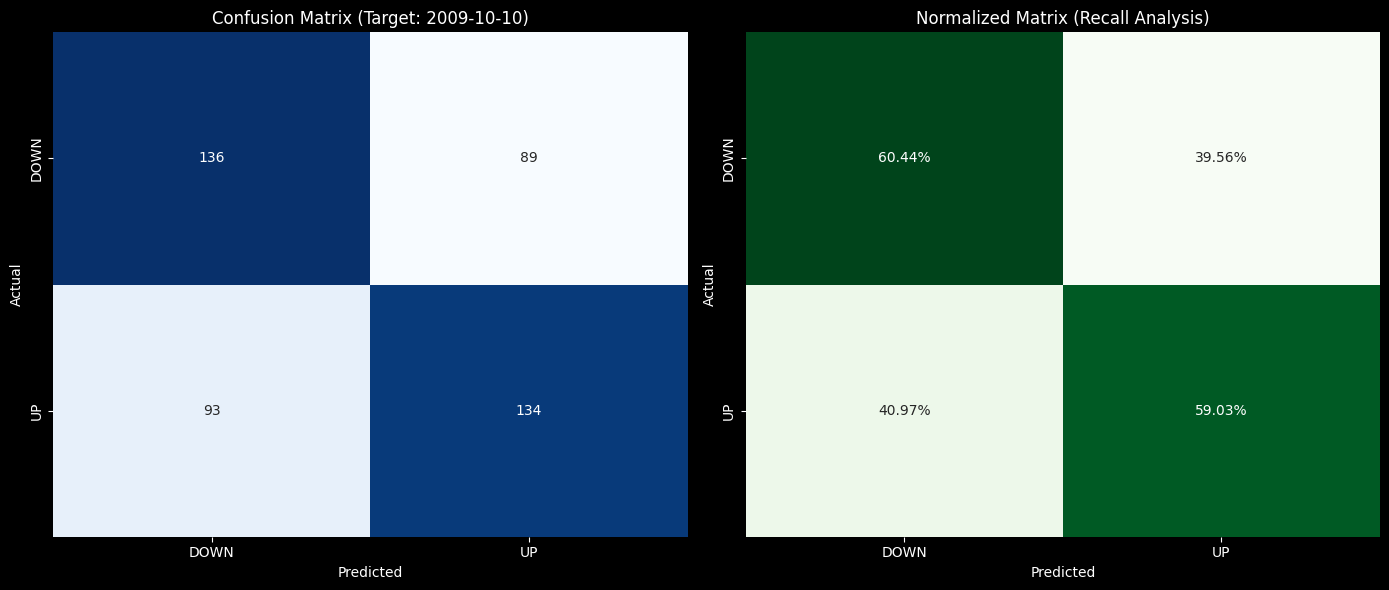


📝 Detailed Classification Report:
              precision    recall  f1-score   support

        DOWN     0.5939    0.6044    0.5991       225
          UP     0.6009    0.5903    0.5956       227

    accuracy                         0.5973       452
   macro avg     0.5974    0.5974    0.5973       452
weighted avg     0.5974    0.5973    0.5973       452



In [7]:
# 5. Visualization
print("\n" + "="*80)
print("📊 BEST MODEL DIAGNOSTICS")
print("="*80)

# 1. Confusion Matrix
cm = confusion_matrix(best["y_test"], best["y_pred"])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
ax[0].set_title(f"Confusion Matrix (Target: {TARGET_DATE})")
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_xticklabels(['DOWN', 'UP'])
ax[0].set_yticklabels(['DOWN', 'UP'])

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', ax=ax[1], cbar=False)
ax[1].set_title(f"Normalized Matrix (Recall Analysis)")
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
ax[1].set_xticklabels(['DOWN', 'UP'])
ax[1].set_yticklabels(['DOWN', 'UP'])

plt.tight_layout()
plt.show()

# 2. Detailed Report
print("\n📝 Detailed Classification Report:")
print(classification_report(best["y_test"], best["y_pred"], target_names=["DOWN", "UP"], digits=4))
